# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_competition_extention'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [9]:
import utilities.helper
import trodes.read_exported

In [10]:
import shutil
from pathlib import Path


In [11]:
FONTSIZE = 20

In [12]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [13]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [14]:
LFP_SPECTRAL_DF = pd.read_pickle("../2024_01_30_rce2_spectral_preprocessing/proc/rce_pilot_2_10_per_trial_spectral_bans_sleap.pkl")

In [15]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"lose": "#951a1d",
"alone_rewarded": "#0499af",
"win": "#3853a3",
"omission": "orange"}

In [16]:
session_types = ["training", "omission", "both", "novel"]

In [17]:
BAND_TO_FREQ_PLOT = {'theta': (4, 12), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

In [18]:
preprocessing_type = "zscored"

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [19]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [20]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [21]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [22]:
LFP_SPECTRAL_DF.columns

Index(['tracked_subject', 'box_number', 'sleap_name', 'video_name',
       'current_subject', 'tone_start_frame', 'reward_start_frame',
       'tone_stop_frame', 'condition', 'competition_closeness',
       ...
       'baseline_subject_thorax_to_reward_port',
       'baseline_subject_thorax_velocity', 'baseline_video_timestamps',
       'trial_agent_locations', 'trial_agent_thorax_to_reward_port',
       'trial_agent_thorax_velocity', 'trial_subject_locations',
       'trial_subject_thorax_to_reward_port', 'trial_subject_thorax_velocity',
       'trial_video_timestamps'],
      dtype='object', length=275)

## Power plots

In [23]:
LFP_SPECTRAL_DF["trial_label"]

0        win
1       lose
2       lose
3       lose
4       lose
        ... 
1364    lose
1365    lose
1366    lose
1367    lose
1368    lose
Name: trial_label, Length: 1369, dtype: object

In [24]:
LFP_SPECTRAL_DF["experiment"]

0       standard
1       standard
2       standard
3       standard
4       standard
          ...   
1364       novel
1365       novel
1366       novel
1367       novel
1368       novel
Name: experiment, Length: 1369, dtype: object

In [25]:
LFP_SPECTRAL_DF["experiment_and_label"] = LFP_SPECTRAL_DF.apply(lambda x: "{}_{}".format(x["experiment"], x["trial_label"]) if x["experiment"] != x["trial_label"] else x["experiment"], axis=1)

In [26]:
LFP_SPECTRAL_DF["experiment_and_label"] = LFP_SPECTRAL_DF["experiment_and_label"].apply(lambda x: x.replace("omission_rewarded", "alone_rewarded").replace("standard_rewarded", "alone_rewarded").replace("standard", "").strip("_"))

In [27]:
LFP_SPECTRAL_DF["experiment_and_label"].unique()

array(['win', 'lose', 'alone_rewarded', 'omission', 'both_rewarded',
       'novel_lose', 'novel_win'], dtype=object)

In [28]:
power_columns = set([col.replace("baseline_", "").replace("trial_", "") for col in LFP_SPECTRAL_DF.columns if "all_frequencies" in col])


In [29]:
power_columns

{'BLA_LH_coherence_all_frequencies',
 'BLA_LH_granger_all_frequencies',
 'BLA_MD_coherence_all_frequencies',
 'BLA_MD_granger_all_frequencies',
 'BLA_mPFC_coherence_all_frequencies',
 'BLA_mPFC_granger_all_frequencies',
 'BLA_power_all_frequencies',
 'BLA_vHPC_coherence_all_frequencies',
 'BLA_vHPC_granger_all_frequencies',
 'LH_BLA_granger_all_frequencies',
 'LH_MD_coherence_all_frequencies',
 'LH_MD_granger_all_frequencies',
 'LH_mPFC_coherence_all_frequencies',
 'LH_mPFC_granger_all_frequencies',
 'LH_power_all_frequencies',
 'LH_vHPC_coherence_all_frequencies',
 'LH_vHPC_granger_all_frequencies',
 'MD_BLA_granger_all_frequencies',
 'MD_LH_granger_all_frequencies',
 'MD_mPFC_coherence_all_frequencies',
 'MD_mPFC_granger_all_frequencies',
 'MD_power_all_frequencies',
 'MD_vHPC_coherence_all_frequencies',
 'MD_vHPC_granger_all_frequencies',
 'mPFC_BLA_granger_all_frequencies',
 'mPFC_LH_granger_all_frequencies',
 'mPFC_MD_granger_all_frequencies',
 'mPFC_power_all_frequencies',
 'mPFC

In [30]:
all_frequencies_col = [col for col in LFP_SPECTRAL_DF.columns if "all_frequencies" in col]

averaged_LFP_SPECTRAL_DF = LFP_SPECTRAL_DF.copy()
for col in all_frequencies_col:
    averaged_LFP_SPECTRAL_DF[col] = averaged_LFP_SPECTRAL_DF[col].apply(lambda x: np.nanmean(x, axis=0))

In [31]:
if os.path.exists("./proc/plots/spectra"):
    shutil.rmtree("./proc/plots/spectra")

In [32]:
Path("./proc/plots/spectra/png").mkdir(parents=True, exist_ok=True)
Path("./proc/plots/spectra/svg").mkdir(parents=True, exist_ok=True)

vHPC_power_all_frequencies


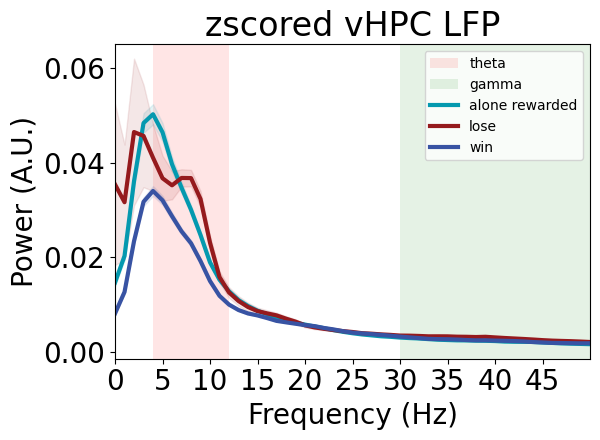

LH_power_all_frequencies


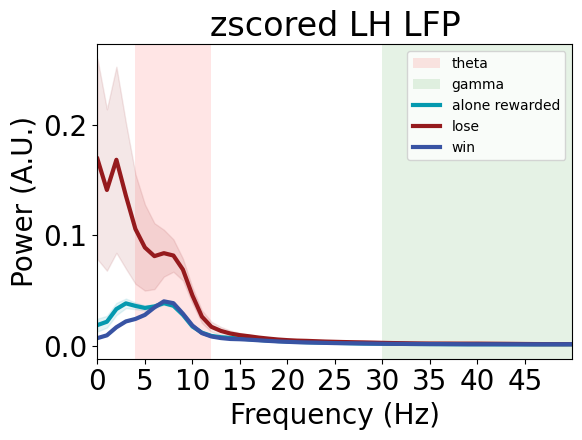

BLA_power_all_frequencies


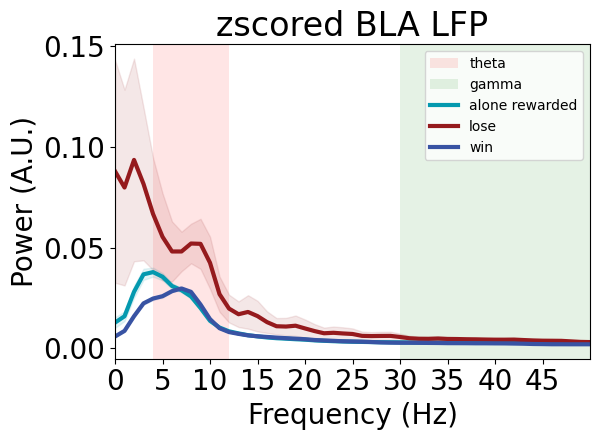

MD_power_all_frequencies


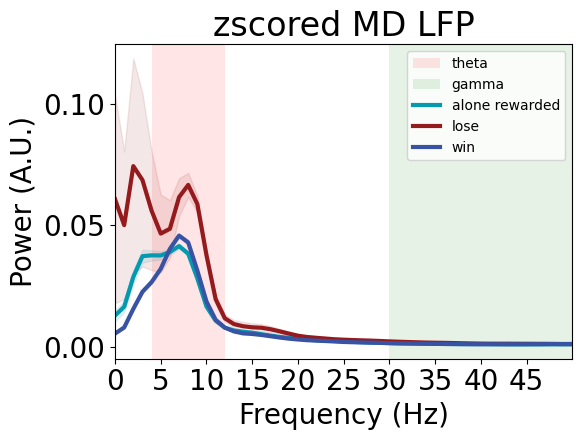

mPFC_power_all_frequencies


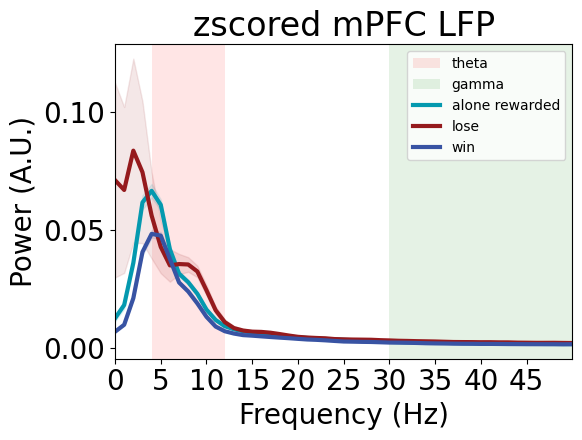

vHPC_power_all_frequencies


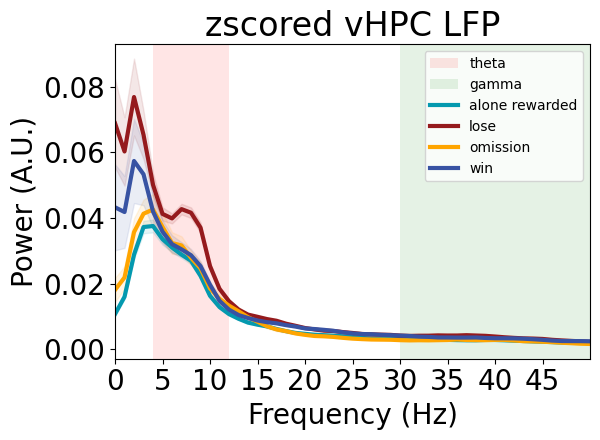

LH_power_all_frequencies


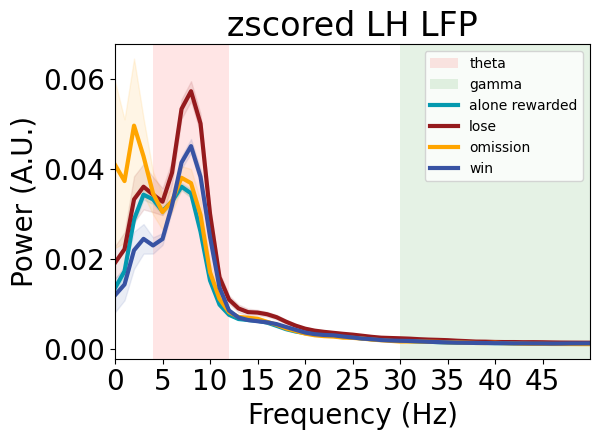

BLA_power_all_frequencies


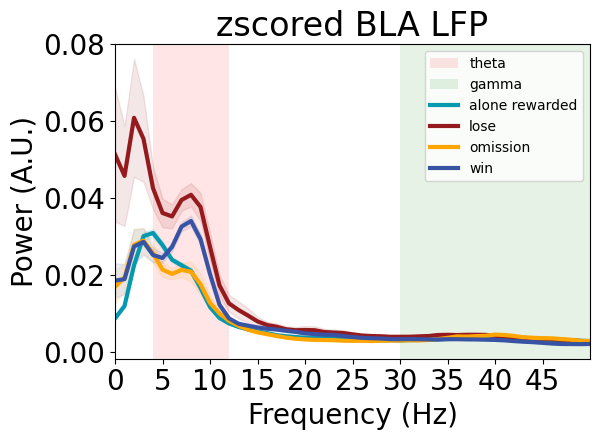

MD_power_all_frequencies


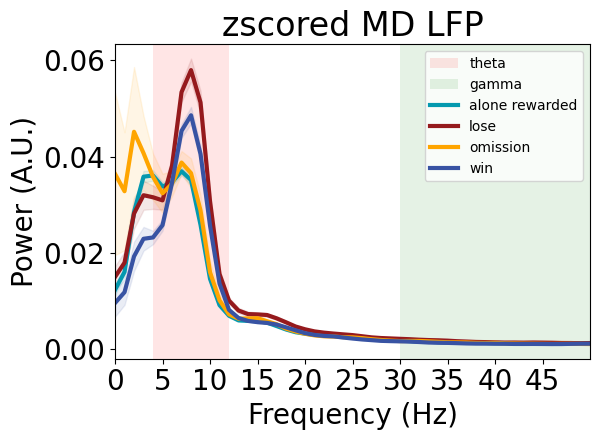

mPFC_power_all_frequencies


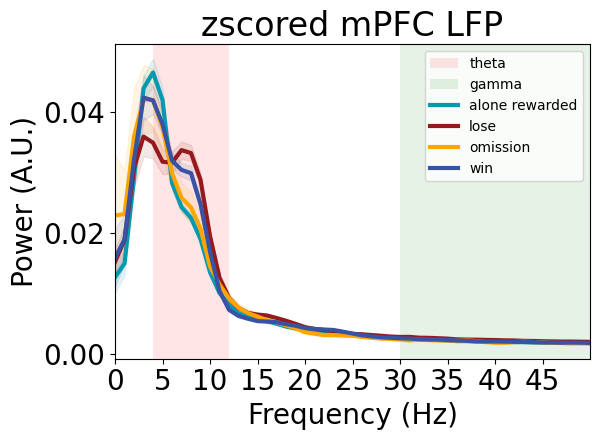

vHPC_power_all_frequencies


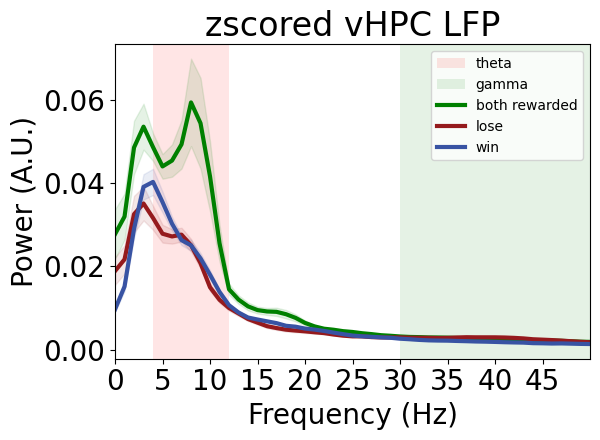

LH_power_all_frequencies


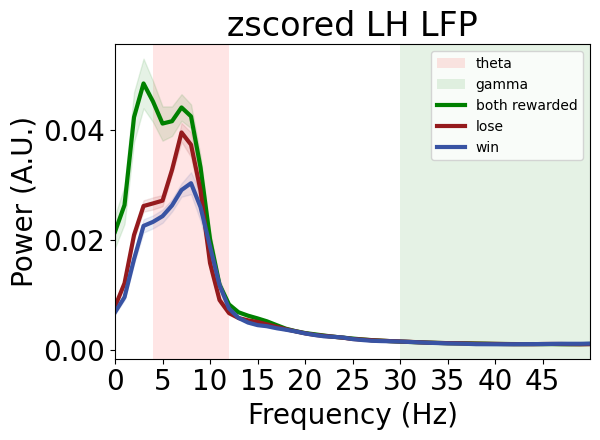

BLA_power_all_frequencies


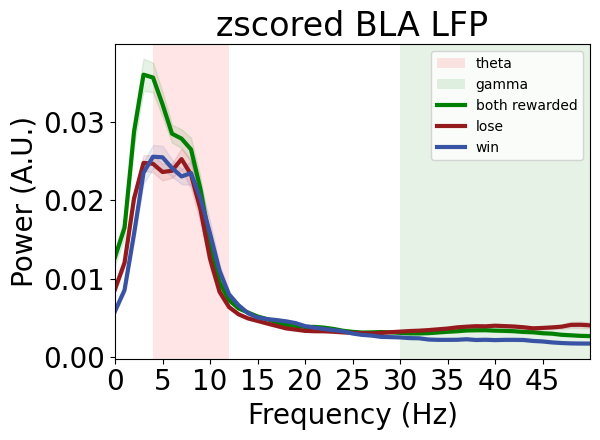

MD_power_all_frequencies


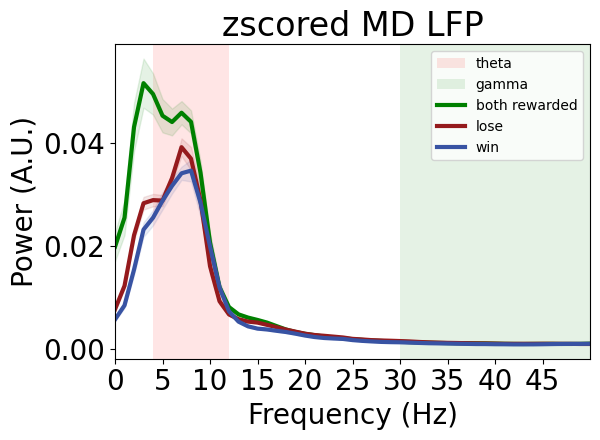

mPFC_power_all_frequencies


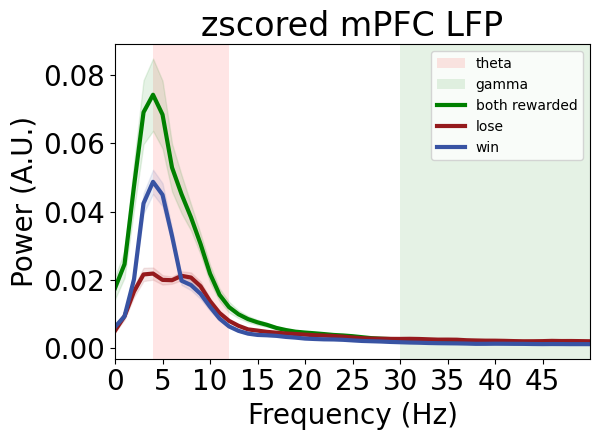

vHPC_power_all_frequencies


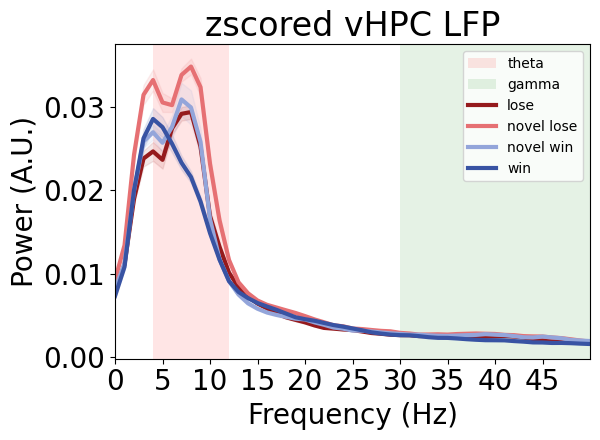

LH_power_all_frequencies


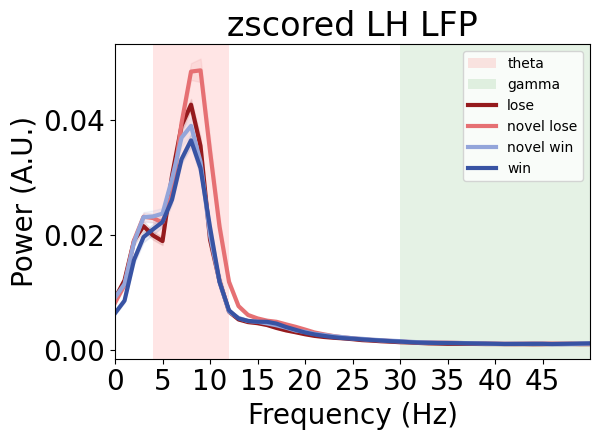

BLA_power_all_frequencies


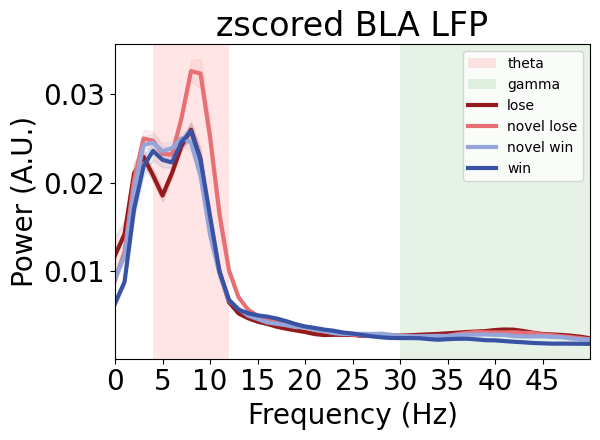

MD_power_all_frequencies


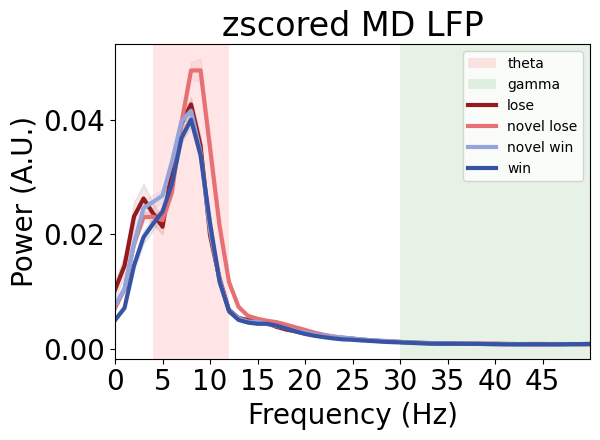

mPFC_power_all_frequencies


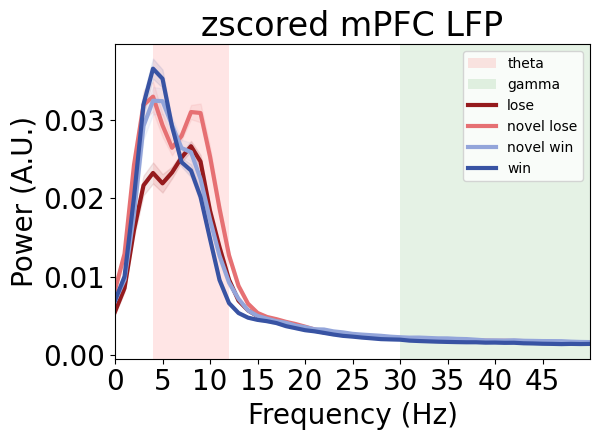

In [33]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

for session in session_types:
    session_df = averaged_LFP_SPECTRAL_DF[averaged_LFP_SPECTRAL_DF["recording"].str.contains(session)].copy()
    
    # Apply the function to each group and each column
    grouped_all_trials_df = session_df.groupby('experiment_and_label').agg({col: stack_arrays for col in all_frequencies_col})

    grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()    
    
    for column in power_columns:
        if "power" not in column:
            continue
        fig, ax = plt.subplots()
        print(column)
        baseline_column = "baseline_{}".format(column)
        trial_column = "trial_{}".format(column)
        plot_title = "{}".format(column).replace("_all_frequencies", "").replace("_granger", "").replace("_power", "").replace("_coherence", "")
        if "granger" in column:
            plot_title = plot_title.replace("_", " to ")
        else:
            plot_title = plot_title.replace("_", " and ")

        plt.title("{} {} LFP".format(preprocessing_type, plot_title))
        
        plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
        
        if "power" in column:
            plt.ylabel("Power (A.U.)", fontsize=FONTSIZE)

        elif "coherence" in column:
            plt.ylabel("Coherence", fontsize=FONTSIZE)
        
        elif "granger" in column:
            plt.ylabel("Granger", fontsize=FONTSIZE)

        else:
            plt.ylabel("(A.U.)", fontsize=FONTSIZE)

        
        plt.xlim(low_freq, high_freq-1) 
        plt.xticks(np.arange(low_freq, high_freq-1, 5))

        for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
            ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
        
        if "power" in column:
            # plt.ylim(0,0.01)
            # plt.yscale("log")
            # plt.ylim((10**-3.5,10**-0.5))
            pass
        else:
            plt.ylim(0, 1)
            
        for index, row in grouped_all_trials_df.iterrows():   
            #### DURING TRIAL ####
            mean_power = np.nanmean(row[trial_column], axis=0)[low_freq: high_freq]
            # nans, x= nan_helper(mean_power)
            # mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
            
            sem_power = np.nanstd(row[trial_column], axis=0) / ((row[trial_column].shape[0])**0.5)
            sem_power = sem_power[low_freq: high_freq]
            # nans, x= nan_helper(sem_power)
            # sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])   

            try:
                ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                label=" ".join("{}".format(row["experiment_and_label"]).split("_")), linewidth=3, linestyle="-", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

                plt.fill_between(current_frequencies, 
                mean_power - sem_power, mean_power + sem_power, \
                alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
            except Exception as e: 
                print(e)
        plt.legend(fontsize=10)
        plt.tight_layout()
        
        column = column.replace("_all_frequencies", "")
        spectra_type = column.split("_")[-1]
        brain_regions = "_".join((column.split("_")[:-1]))
        
        plt.savefig("./proc/plots/spectra/png/{}_{}_{}_{}_spectra.png".format(spectra_type, session, brain_regions, preprocessing_type))
        plt.savefig("./proc/plots/spectra/svg/{}_{}_{}_{}_spectra.svg".format(spectra_type, session, brain_regions, preprocessing_type))
        plt.show()
        
    

In [34]:
if os.path.exists("./proc/plots/spectra/subj"):
    shutil.rmtree("./proc/plots/spectra/subj")

In [35]:
Path("./proc/plots/spectra/subj/png").mkdir(parents=True, exist_ok=True)
Path("./proc/plots/spectra/subj/svg").mkdir(parents=True, exist_ok=True)

In [36]:
brain_region_to_ylim = {"BLA": 0.2, "LH": 0.2, "MD": 0.2, "mPFC": 0.2, "vHPC": 0.2}

vHPC_power_all_frequencies
0.30364990234375


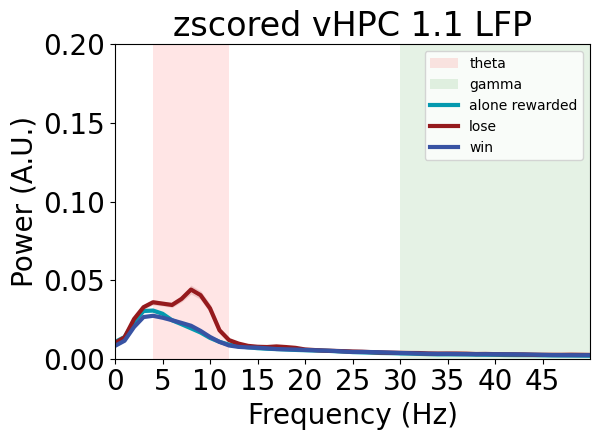

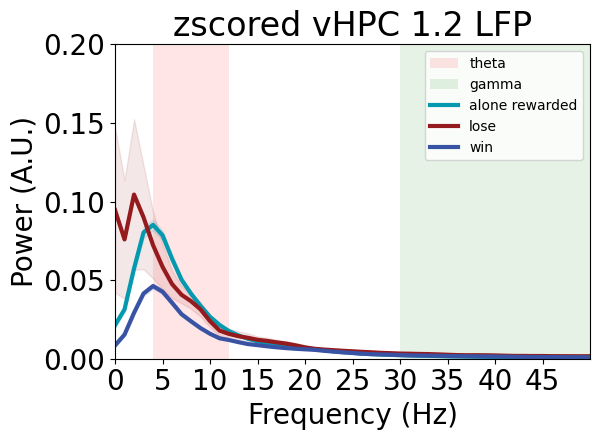

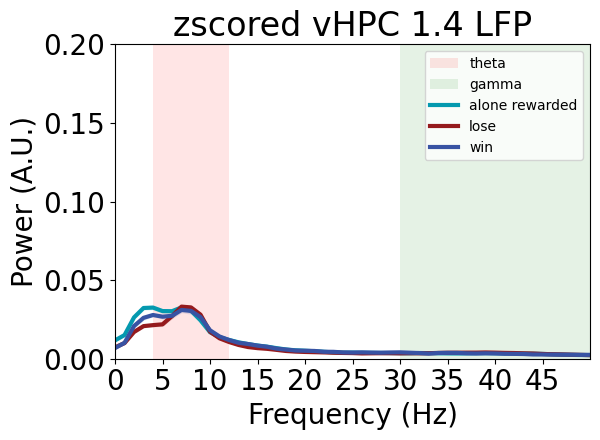

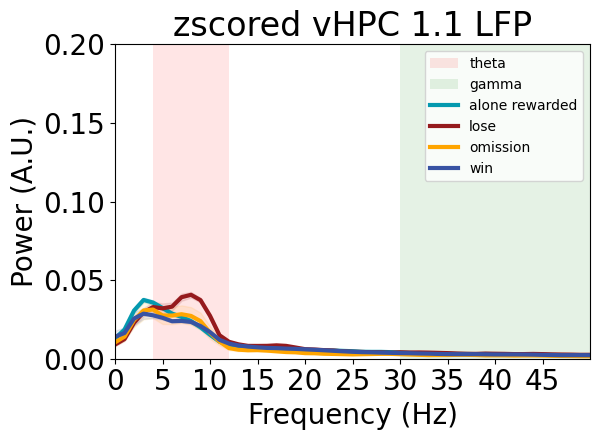

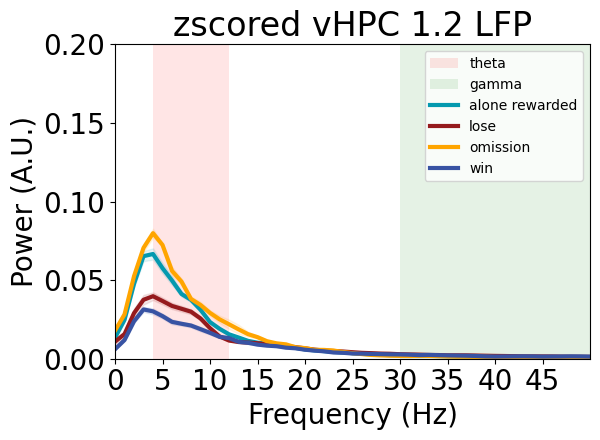

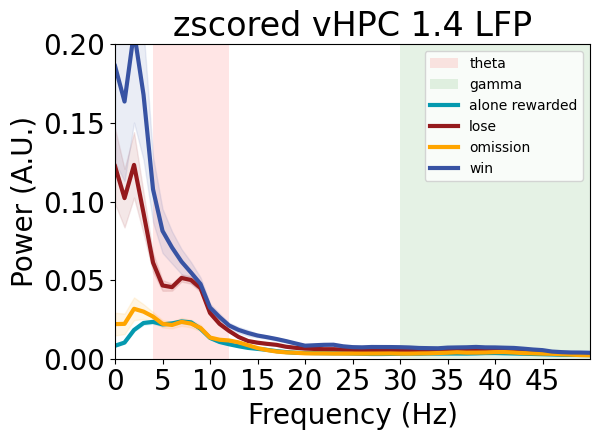

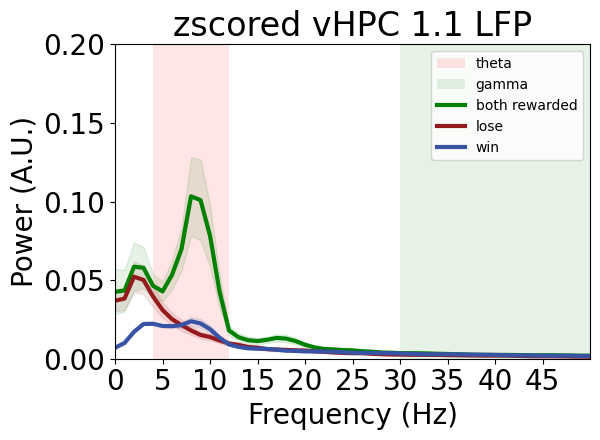

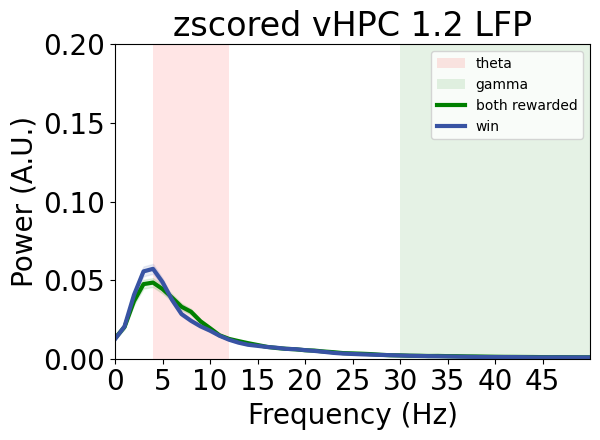

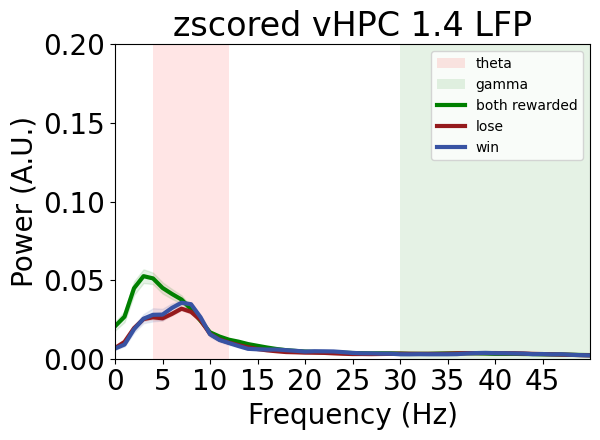

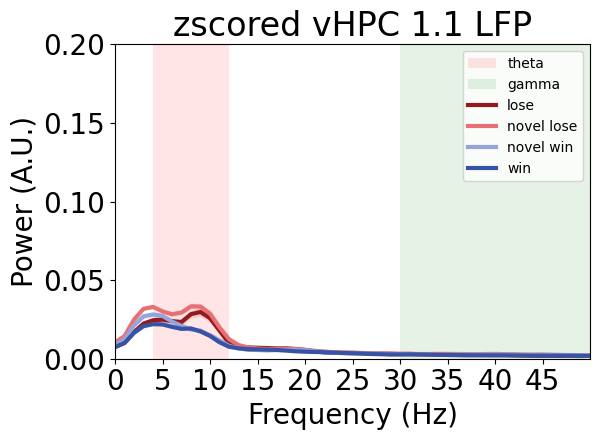

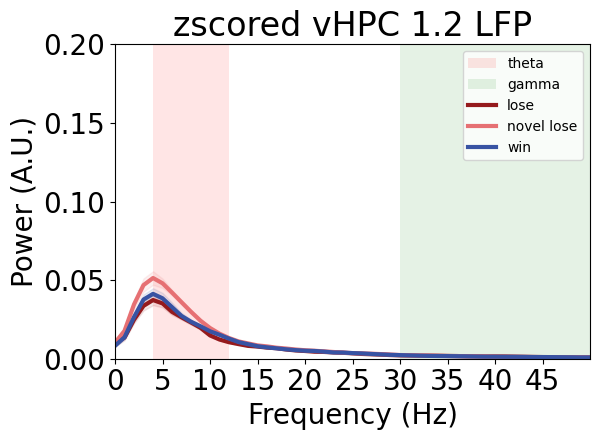

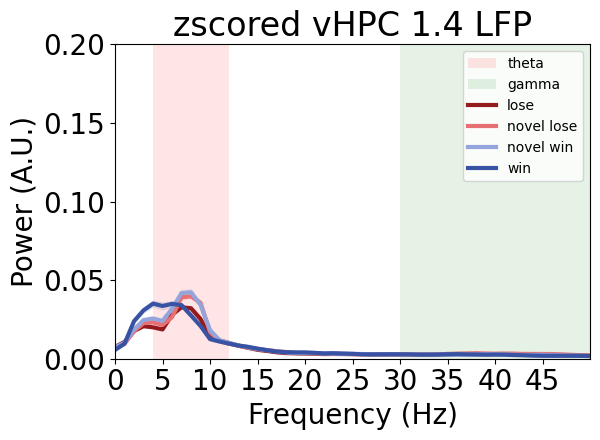

LH_power_all_frequencies
0.45440673828125


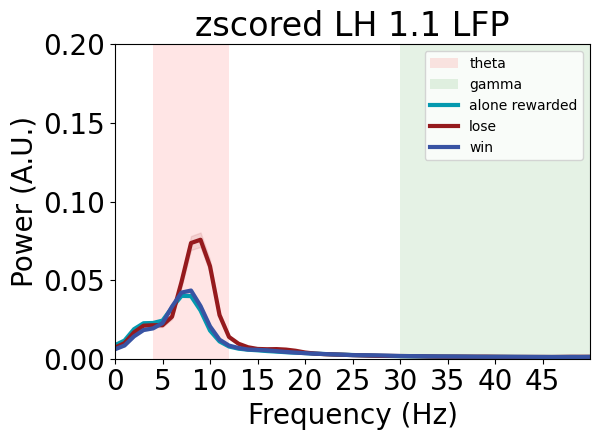

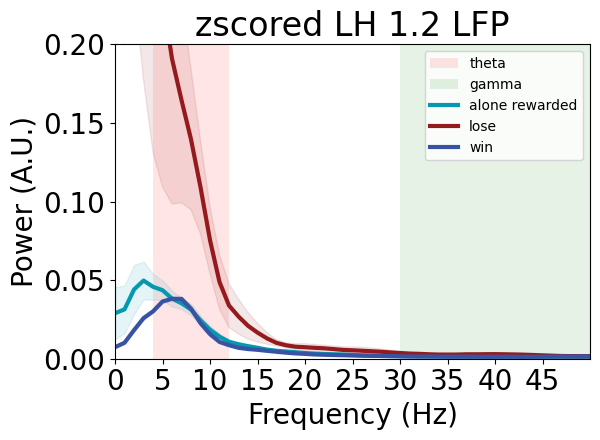

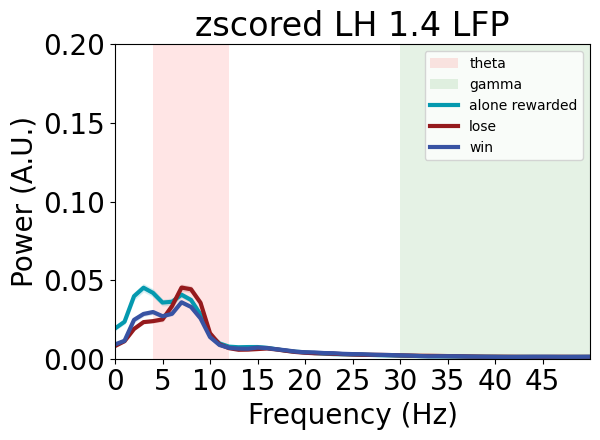

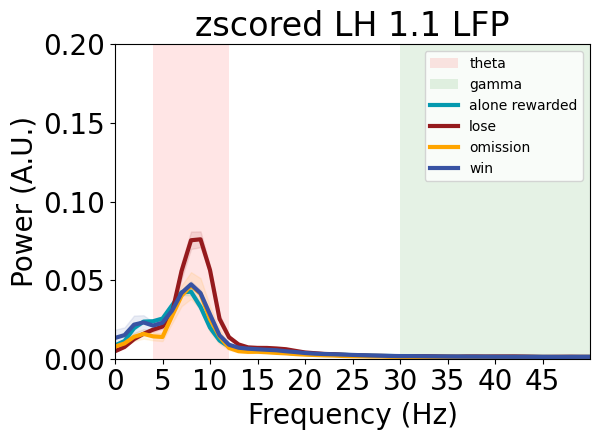

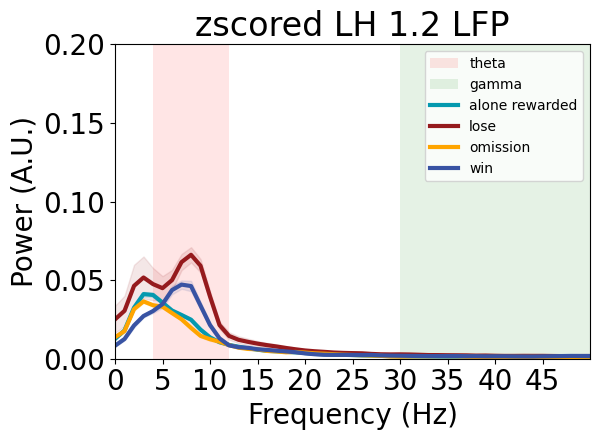

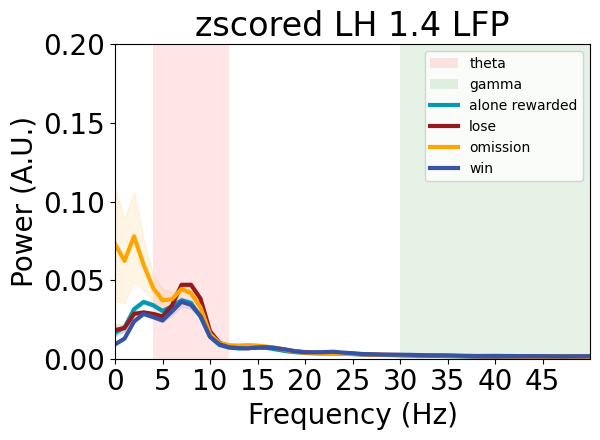

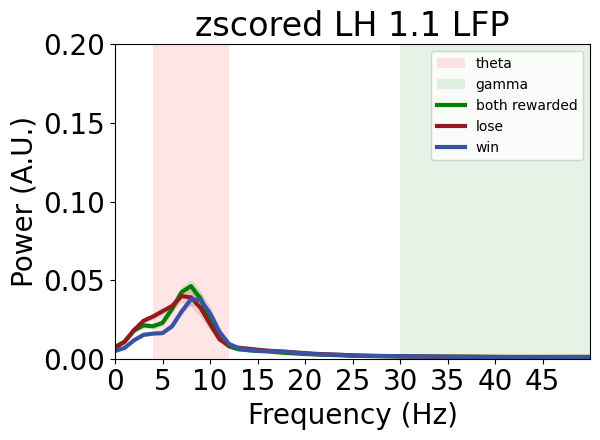

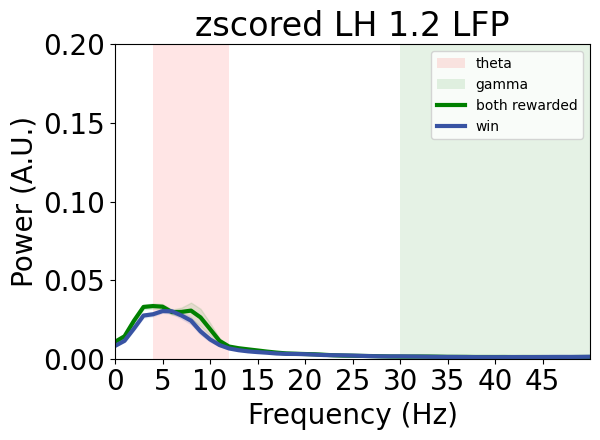

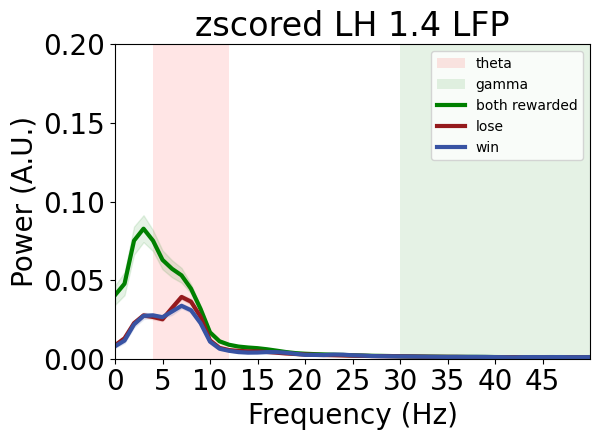

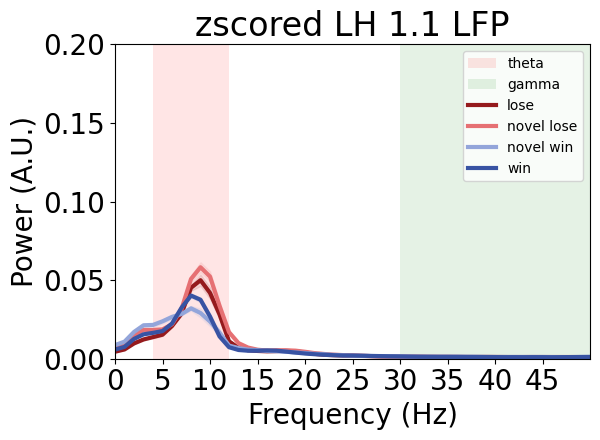

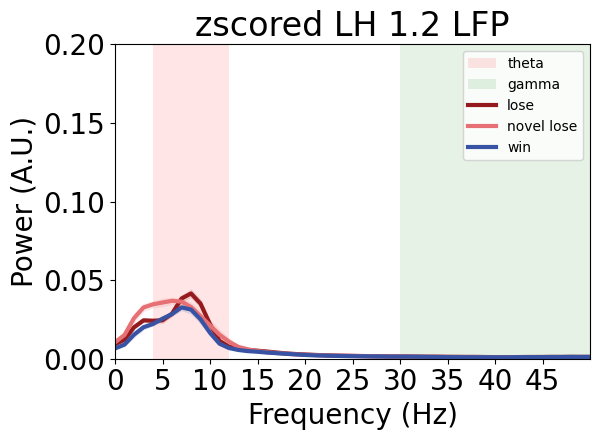

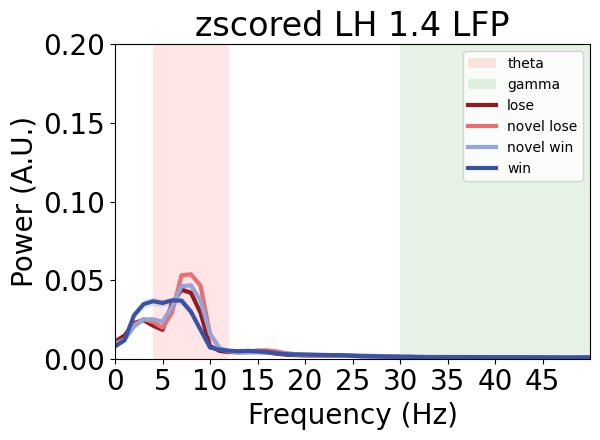

BLA_power_all_frequencies
2.7978515625


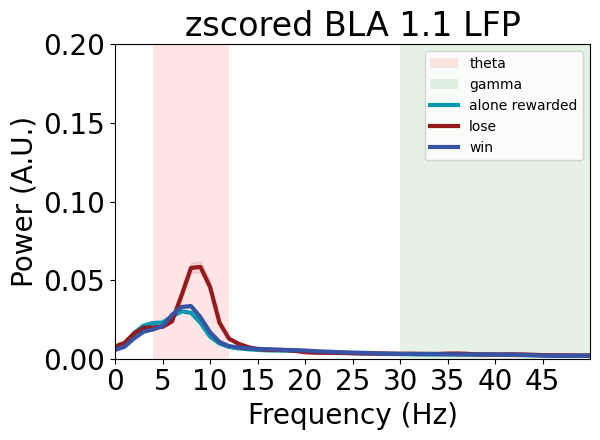

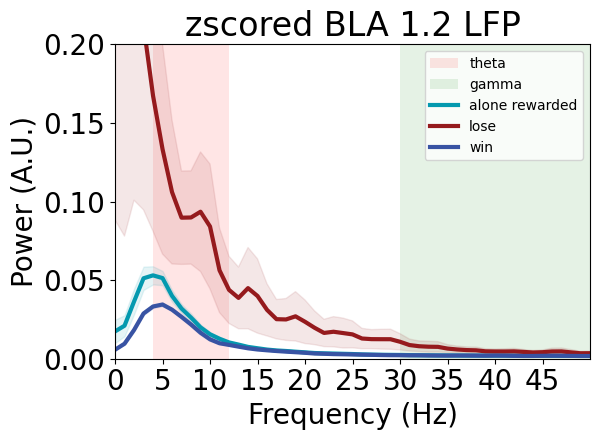

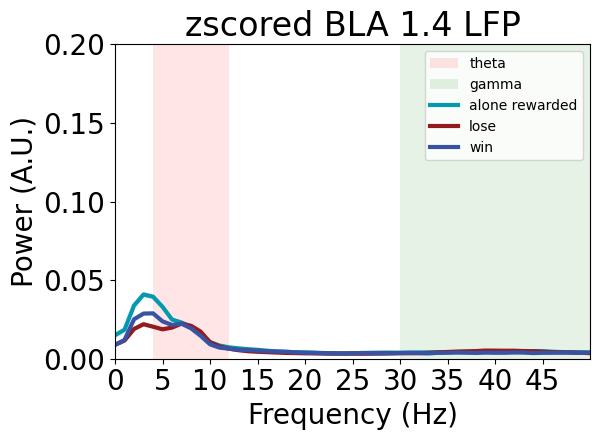

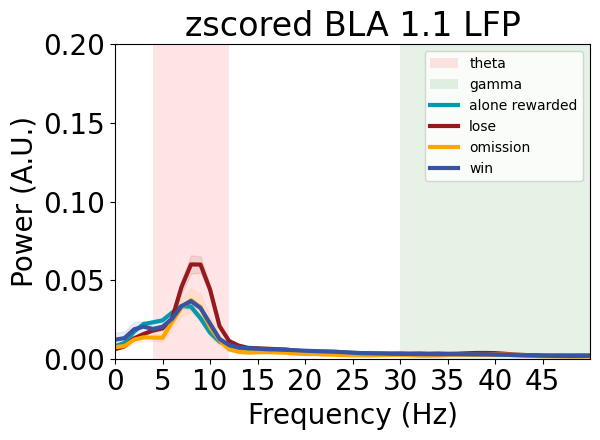

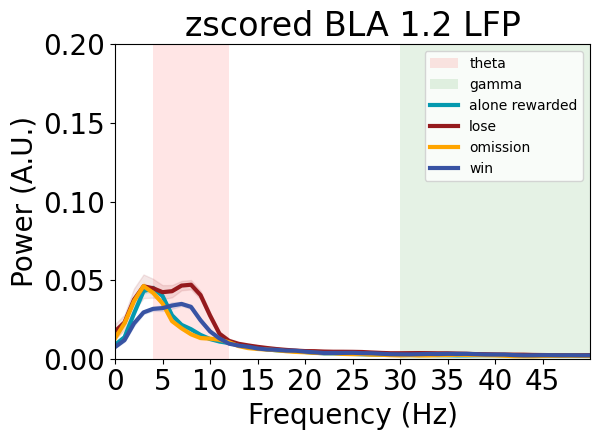

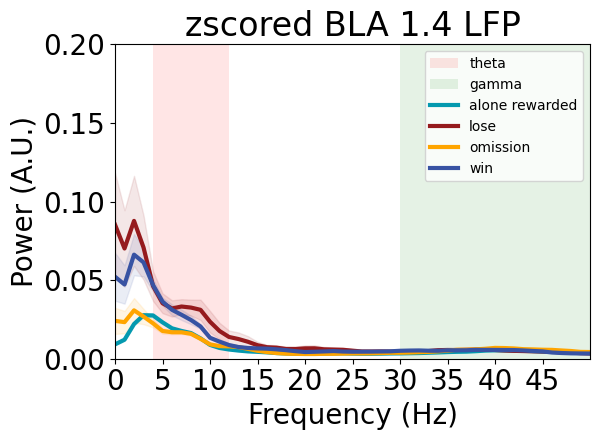

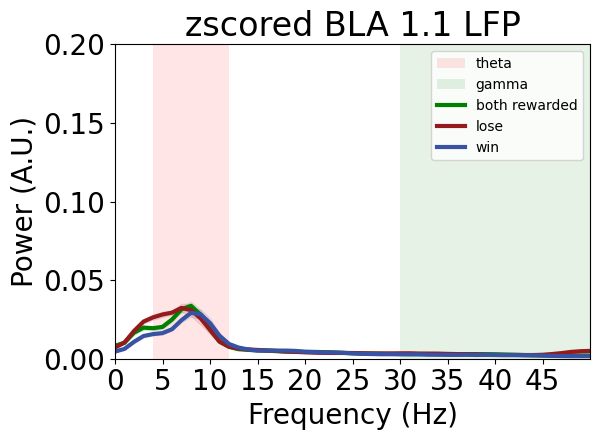

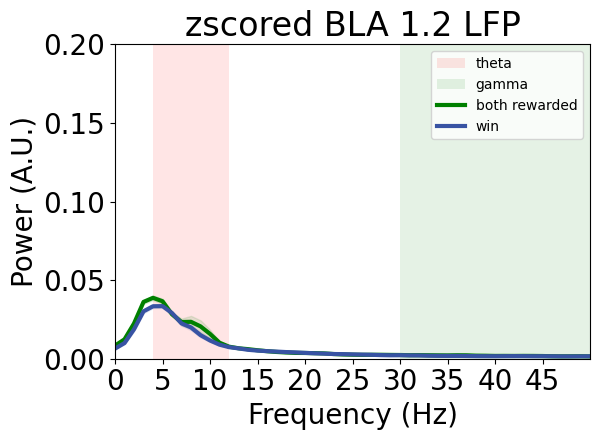

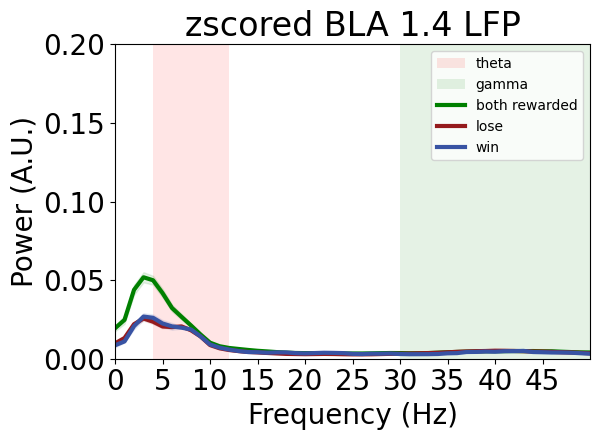

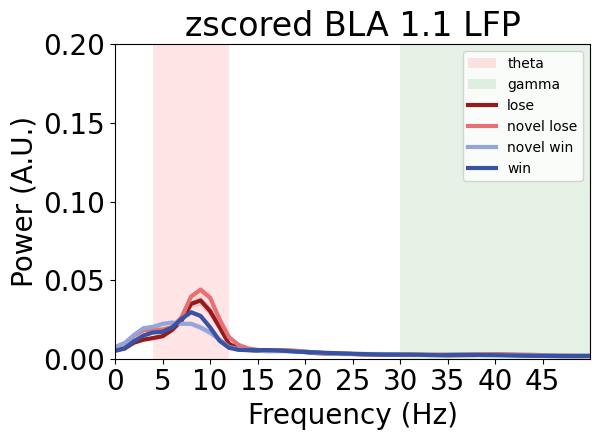

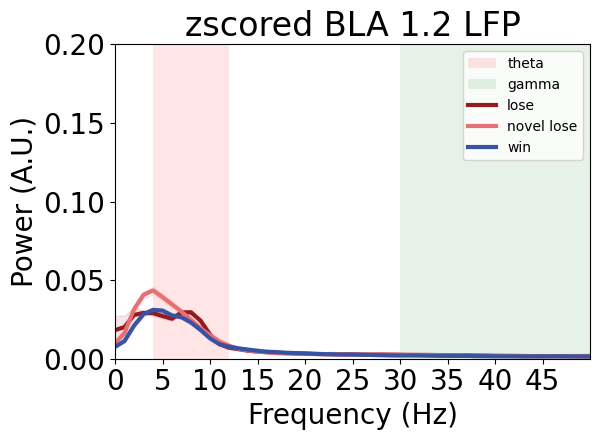

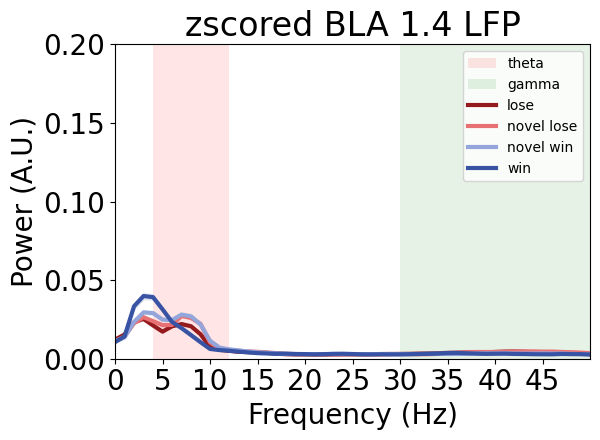

MD_power_all_frequencies
0.6390380859375


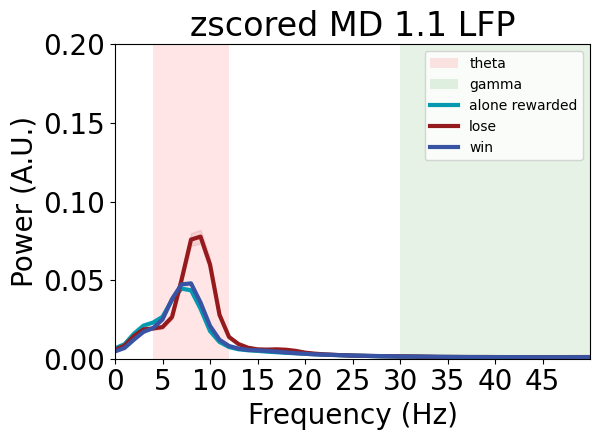

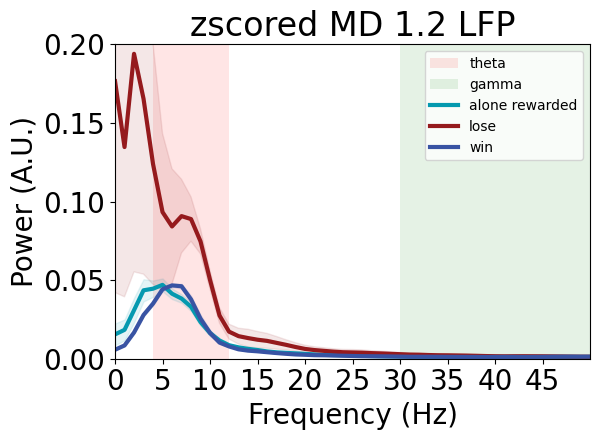

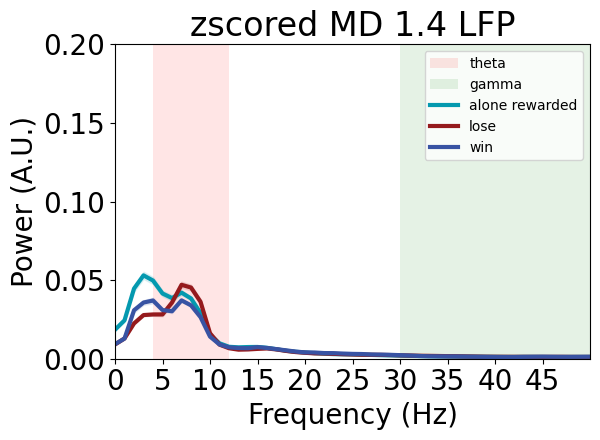

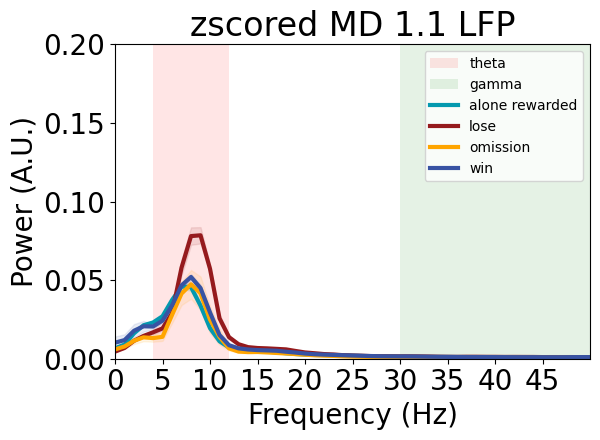

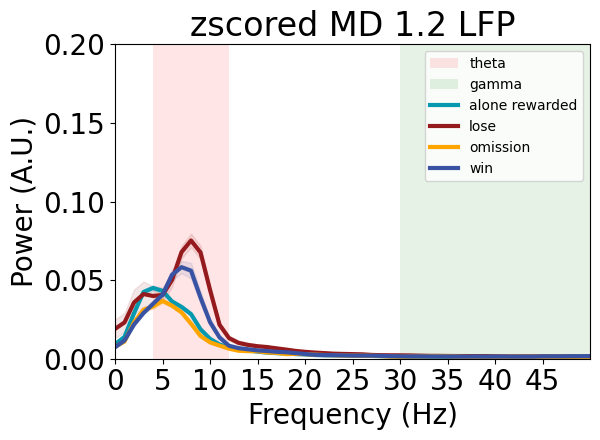

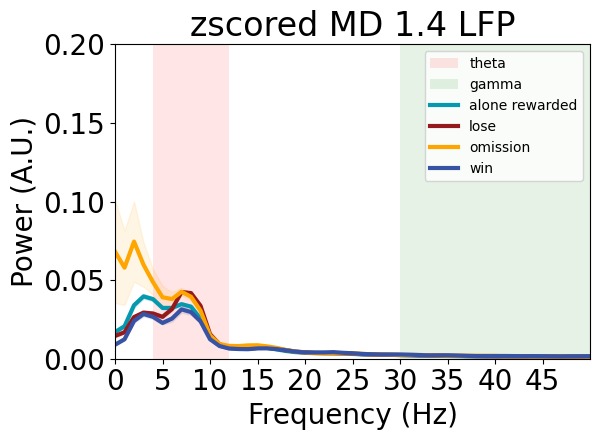

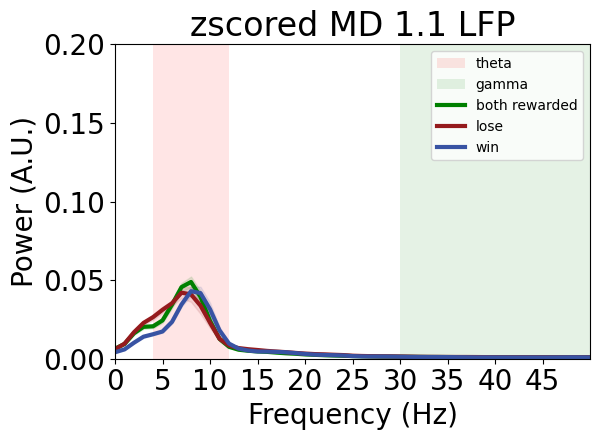

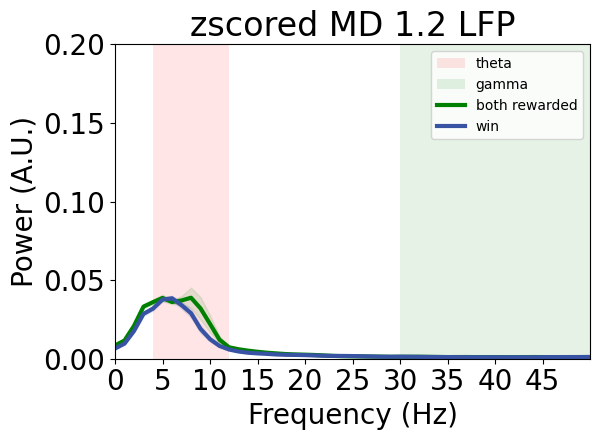

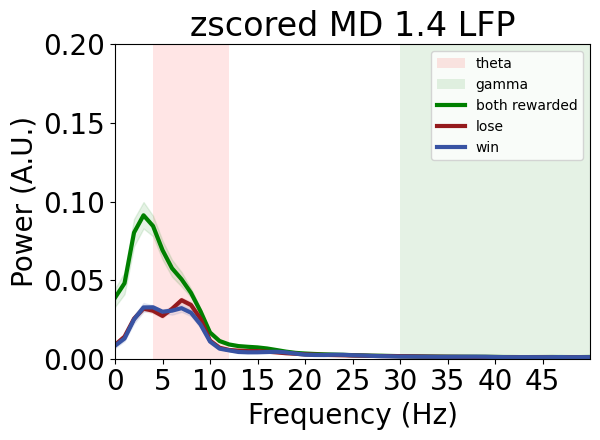

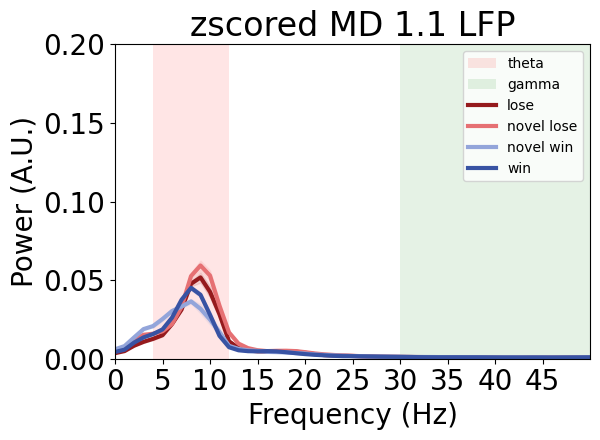

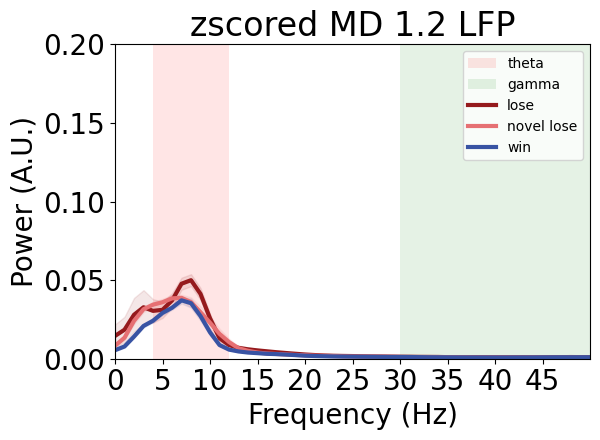

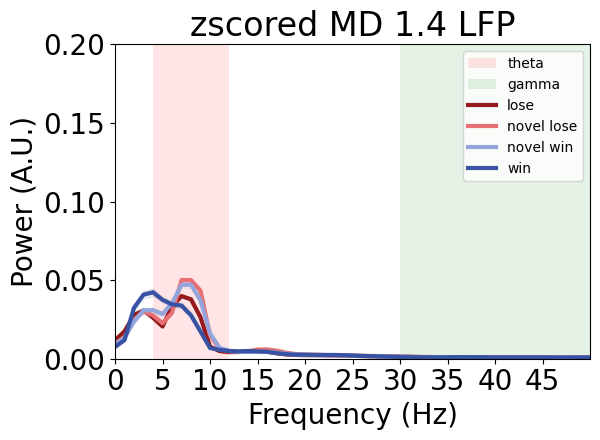

mPFC_power_all_frequencies
0.145263671875


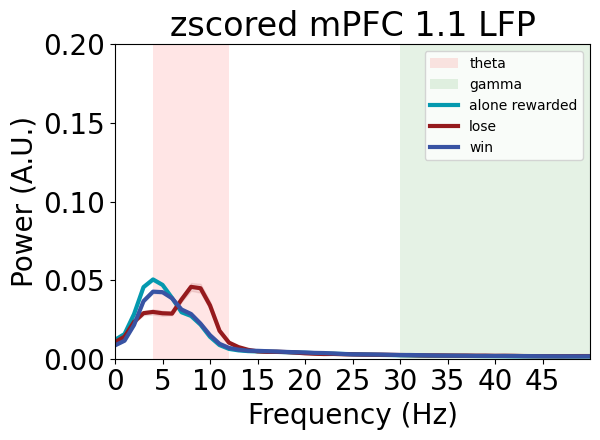

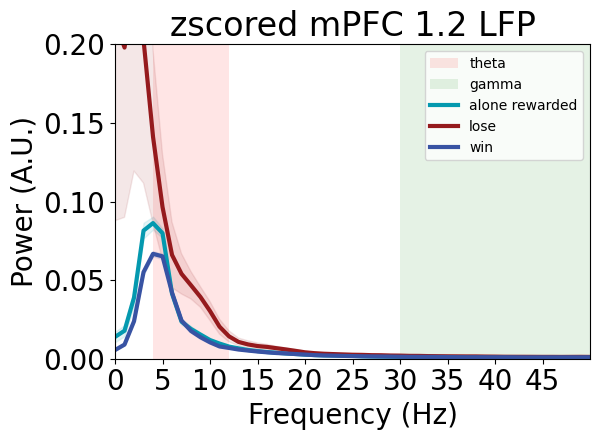

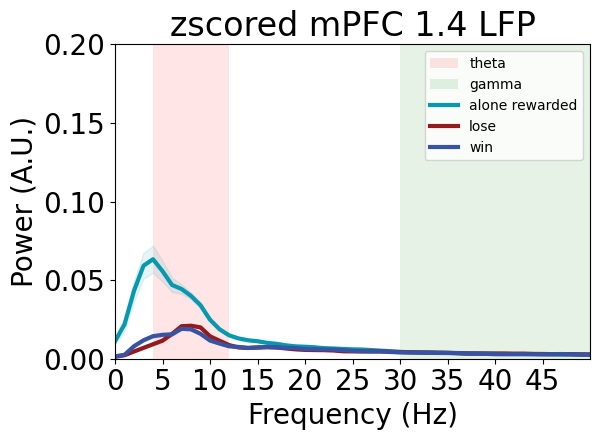

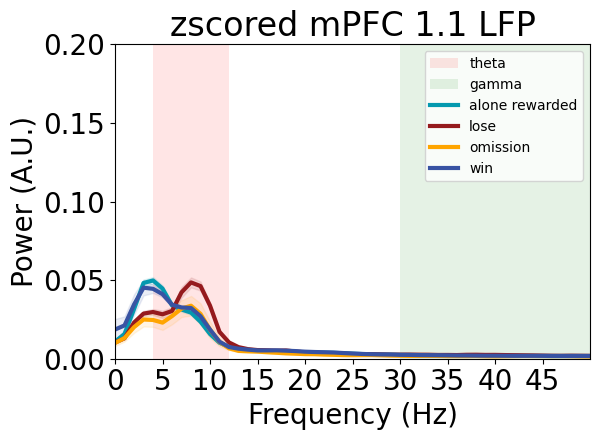

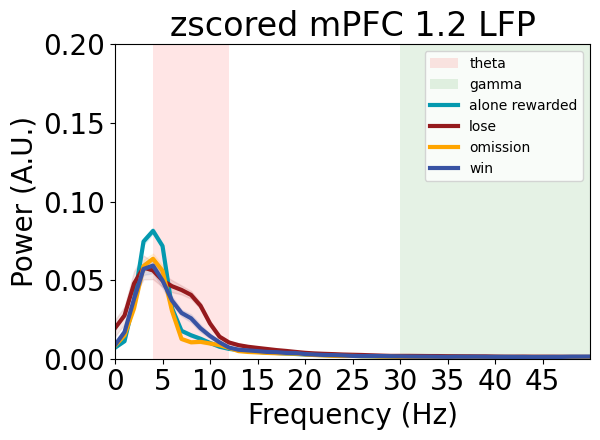

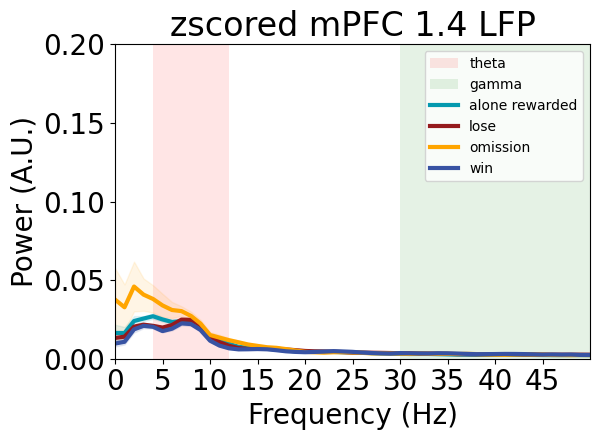

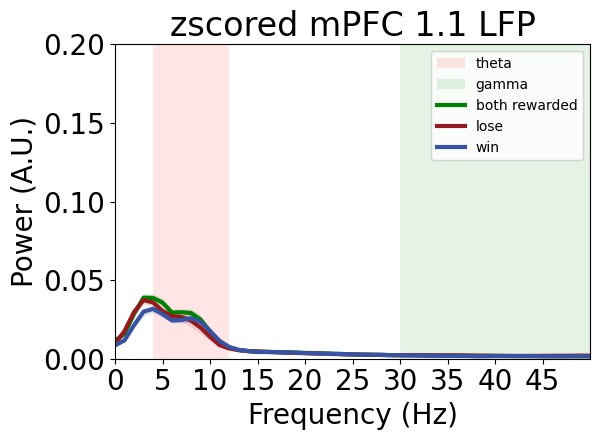

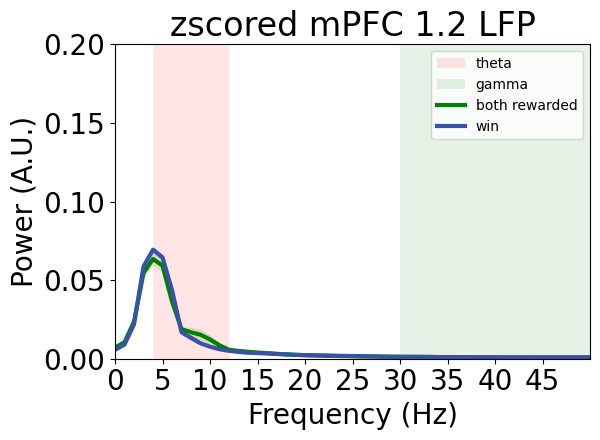

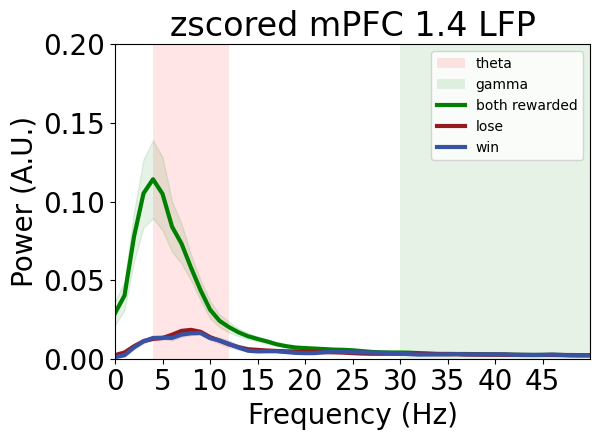

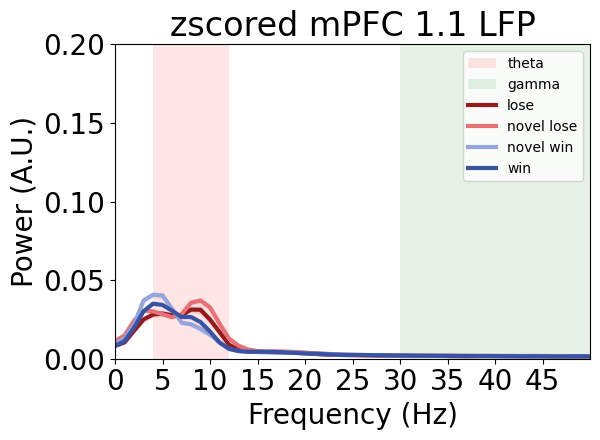

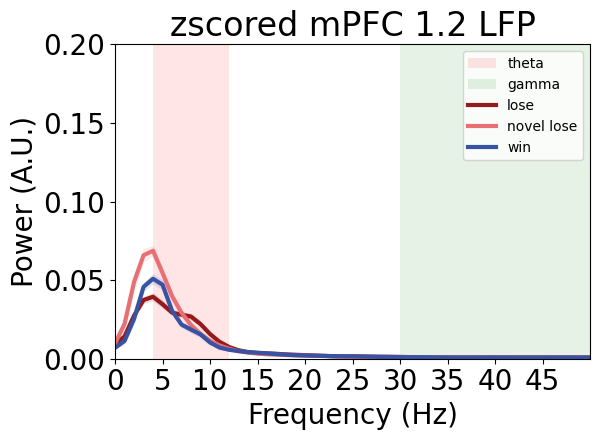

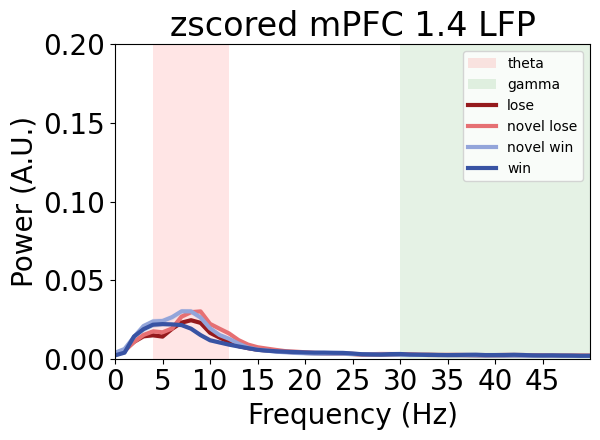

In [37]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

# Iterating through each power column
for column in power_columns:
    if "power" not in column:
        continue

    print(column)
    baseline_column = "baseline_{}".format(column)
    trial_column = "trial_{}".format(column)
    
    plot_title = "{}".format(column).replace("_all_frequencies", "").replace("_granger", "").replace("_power", "").replace("_coherence", "")
    if "granger" in column:
        plot_title = plot_title.replace("_", " to ")
    else:
        plot_title = plot_title.replace("_", " and ")
    
    session_max = averaged_LFP_SPECTRAL_DF[trial_column].apply(lambda x: np.median(x[low_freq:high_freq])).max() * 10
    print(session_max)
    
    column = column.replace("_all_frequencies", "")
    spectra_type = column.split("_")[-1]
    brain_regions = "_".join((column.split("_")[:-1]))
    
    for session in session_types:
        session_df = averaged_LFP_SPECTRAL_DF[averaged_LFP_SPECTRAL_DF["recording"].str.contains(session)].copy()
        
        
        
        for subj in session_df["current_subject"].unique():
            subj_df = session_df[session_df["current_subject"] == subj].copy()

            # Apply the function to each group and each column
            grouped_all_trials_df = subj_df.groupby('experiment_and_label').agg({col: stack_arrays for col in [baseline_column, trial_column]})
            grouped_all_trials_df = pd.DataFrame(grouped_all_trials_df).reset_index()
            
            fig, ax = plt.subplots()
            
            plt.title("{} {} {} LFP".format(preprocessing_type, plot_title, subj))
            plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)

            if "power" in column:
                plt.ylabel("Power (A.U.)", fontsize=FONTSIZE)
            elif "coherence" in column:
                plt.ylabel("Coherence", fontsize=FONTSIZE)
            elif "granger" in column:
                plt.ylabel("Granger", fontsize=FONTSIZE)
            else:
                plt.ylabel("(A.U.)", fontsize=FONTSIZE)
                
            plt.xlim(low_freq, high_freq-1) 
            plt.xticks(np.arange(low_freq, high_freq-1, 5))
            
            # Shading the frequency bands
            for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
                ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
            
            if "power" in column:
                # plt.ylim(0, session_max)
                plt.ylim(0, brain_region_to_ylim[brain_regions])
                pass
            else:
                plt.ylim(0, 1)
            
            for index, row in grouped_all_trials_df.iterrows():   
                #### DURING TRIAL ####
                mean_power = np.nanmean(row[trial_column], axis=0, dtype=float)[low_freq: high_freq]
                sem_power = np.nanstd(row[trial_column], axis=0, dtype=float) / ((row[trial_column].shape[0])**0.5)
                sem_power = sem_power[low_freq: high_freq]

                try:
                    ax = sns.lineplot(x=current_frequencies, y=mean_power, \
                    label=" ".join("{}".format(row["experiment_and_label"]).split("_")), linewidth=3, linestyle="-", color=OUTCOME_TO_COLOR[row["experiment_and_label"]])

                    plt.fill_between(current_frequencies, 
                    mean_power - sem_power, mean_power + sem_power, \
                    alpha=0.1, color=OUTCOME_TO_COLOR[row["experiment_and_label"]])
                except Exception as e: 
                    print(e)
            plt.legend(fontsize=10)
            plt.tight_layout()


            plt.savefig("./proc/plots/spectra/subj/png/{}_{}_{}_{}_{}_spectra.png".format(preprocessing_type, spectra_type, brain_regions, session, subj))
            plt.savefig("./proc/plots/spectra/subj/svg/{}_{}_{}_{}_{}_spectra.svg".format(preprocessing_type, spectra_type, brain_regions, session, subj))
            plt.show()